# Simulación. 
## Examen parcial 2 
### Sergio Arnaud Gómez, 000159189

---
---

In [1]:
from math import exp
from numpy.random import normal,rand, exponential, geometric,poisson
import seaborn as sn
from numpy import linspace
import numpy as np
from scipy.stats import kstest
from scipy.stats import norm as dnorm
from math import factorial
import random
import pymc3 as pm
import matplotlib.pyplot as plt

---
---

## Pregunta 1

- Aplicar el algoritmo de Metropolis-Hastings para simular 500 observaciones de la distribución doble exponencial con densidad:

$$ f(x) = \frac{\lambda}{2}e^{ - \lambda|x|} \quad x\in \mathbb{R}$$
Usar la distribución normal como distribución propuesta.




- Comprobar estadísticamente con un nivel de confianza del 95 % que la muestra obtenida proviene de las distribución indicada.

#### Solución

Comenzamos por definir f:

In [2]:
# Utilizaremos lambda = 1
def double_exponential(x,lambda_=1):
    return (lambda_/2)*exp(-lambda_*abs(x))
    

Utilizaremos el método de Metrópolis Hastings con caminata aleatoria construyendo el valor en $t+1$ como el valor de t más un error estocástico:

$$y = x + \epsilon_t, \quad  \epsilon_t ∼ N(0,1) ⊥⊥ x$$

Para obtener mejores resultados se utilizó el método de adelgazamiento con $d=10$, es decir, la cadena genera una cadena de $10n$ elementos y se regresa la muestra $X_{10}, X_{20}, X_{30}, ...$

In [3]:
# Función que genera la muestra
def generate_sample(n=500):
    # Adelgazamiento
    k = n*10
    
    # Primer observación
    x = [normal(0,1)]
    
    for i in range(k):
        
        # Se genera valor i+1
        y = normal(x[i],1)
        
        # Razón de hastings (caso caminata aleatoria)
        r = (double_exponential(y))/(double_exponential(x[i]))
        
        # Aceptamos con probabilidad min(1,r)
        if rand() < min(r,1):
            x.append(y)
        else:
            x.append(x[i])
    
    # Adelgazamiento
    return [i for k,i in enumerate(x) if (k%10 == 0 and k>0)]

Generamos 5 muestras de la distribución pedida, un histograma y una estimación no paramétrica de la densidad (línea azul). Comparamos con la densidad teórica (línea naranja). 

Asimismo, realizamos el test de kolmogorov smirnov y mostramos en la gráfica el valor p correspondiente

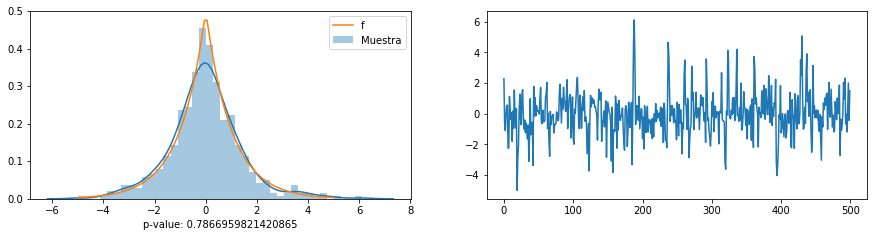

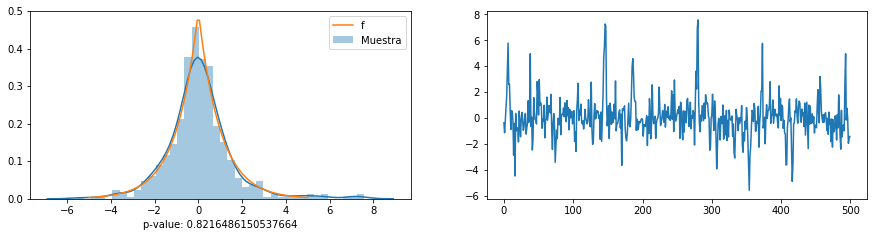

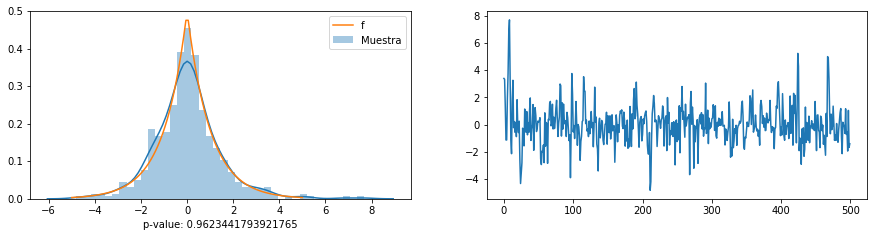

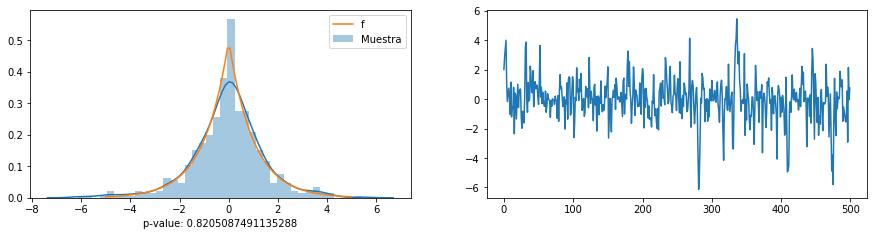

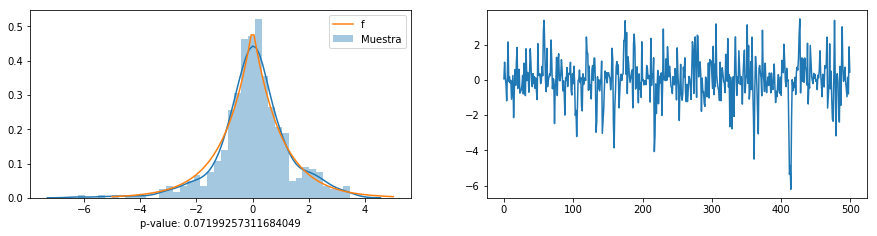

In [4]:
for i in range(5):
    fig = plt.figure(figsize=(15,20))
    x = generate_sample(n=500)

    fig.add_subplot(5,2, 2*i +1)
    sn.distplot(x, bins=40, label='Muestra',axlabel='p-value: {}'.format(kstest(x, 'laplace').pvalue) )
    sn.lineplot(linspace(-5,5,100), list(map(double_exponential,linspace(-5,5,100))), label='f')

    fig.add_subplot(5,2, 2*(i+1))
    sn.lineplot(range(500),x)


Visualmente notamos que la muestra aleatoria sigue una distribución Laplace. Asimismo, el valor p en todas las iteraciones fue mayor a .05 de forma que no hay argumentos para rechazar la hipótesis nula de bondad de ajuste.

(Algo extra)

Muestra utilizando la librería Pymc3 de python 

Sampling 2 chains: 100%|##########| 2000/2000 [00:00<00:00, 2430.92draws/s]
/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


KstestResult(statistic=0.03404827521789336, pvalue=0.19239409538074548)

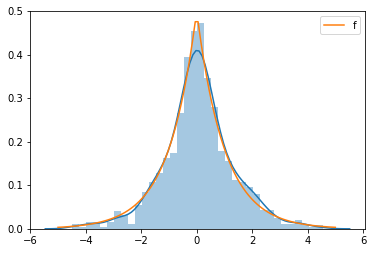

In [5]:
with pm.Model() as m:
    e = pm.Laplace('y',mu=0,b=1)
    r = pm.sample(n=500)
    
sn.distplot(r.get_values('y'))
sn.lineplot(linspace(-5,5,100), list(map(double_exponential,linspace(-5,5,100))), label='f')

kstest(r.get_values('y'), 'laplace')

---
---

## Pregunta 2

Supongan que $V \sim exp(1)$ y consideren que dado $V = v$, $W \sim exp(1/v)$ (entonces, $E(W|V = v) = v$). 

Describir un algoritmo para estimar $P(V W \leq 3)$, que solo requiera generar una variable aleatoria por muestra. Programar el algoritmo y mostrar que funciona, generando 100 muestras.

Comencemos por hacer una muestra de la manera "cruda":

In [6]:
s = 0
for i in range(100):
    v = exponential(1)
    w = exponential(v)
    if v*w <=3:
        s+=1
p = s/100
p

0.84

Por otro lado, notemos que:
    
$$P(V W \leq 3) = E[P(VW \leq 3 \ | \ V=v)]$$

Pero:

$$P(VW \leq 3 \ | \ V=v) =  P (W \leq \frac{3}{v})  | \ V=v $$

Y, dado $V=v$ tendremos que $W \sim exp(1/v)$ luego:

$$P \left(W \leq \frac{3}{v}\right) = 1 - e^{- 3/v^2}$$

De forma que :

$$P(V W \leq 3) = E[1 - e^{- 3/V^2} | \ V=v)] = 1 - E[ e^{- 3/V^2} | \ V=v)]$$

Dicho esto, el algoritmo para estimar dicha probablidad consiste en:

1. Generar 100 observaciones de $V \sim Exp(1)$
2. Para cada una de ellas calcular $w_i = e^{- 3/v_i^2}$
3. Estimar $P(V W \leq 3) = 1 - E[ e^{- 3/V^2} | \ V=v)]$ con $1 - \overline{w} $

In [7]:
arr = []
for i in range(100):
    v = exponential(1)
    w = exp(-3/(v*v))
    arr.append(w)
    
p = 1 - np.mean(arr)
p

0.8596951152677144

---
--- 

## Pregunta 4


Si $\hat{\theta_1} $ y  $\hat{\theta_2}$ son dos estimadores insesgados de θ, encontrar el valor de c que minimiza la varianza del estimador $\theta_c = c  \hat{\theta_1}  + (1-c)\hat{\theta_2}$

##### Demostración:

Sean $ \hat{\sigma_i} := Var(\hat{\theta_i})$ para $i \in \{1,2\}$ : 
$$
\begin{eqnarray}
Var(\theta_c) &=& Var(c \hat{\theta_1}  + (1-c)\hat{\theta_2}) \\ \\ 
&=& c^2Var(\hat{\theta_1}) + (1-c)^2 Var(\hat{\theta_2}) + 2c(1-c)Cov(\hat{\theta_1}, \hat{\theta_2}) \\ \\
&=& c^2\hat{\sigma_1} + (1-c)^2 \hat{\sigma_2} + 2c(1-c) \ Cov(\hat{\theta_1}, \hat{\theta_2}) \\
\end{eqnarray}
$$

Luego:
$$
\underset{c}{\min\{{Var(\theta_c)}\}} = \underset{c}{\min\{{c^2\hat{\sigma_1} + (1-c)^2 \hat{\sigma_2} + 2c(1-c) \ Cov(\hat{\theta_1}, \hat{\theta_2})}\}}
$$


Derivando la segunda expresión:
$$
\begin{eqnarray}
\frac{\partial}{\partial c} Var(\theta_c) &=& \frac{\partial}{\partial c} \left(c^2\hat{\sigma_1} + (1-c)^2 \hat{\sigma_2} + 2c(1-c) \ Cov(\hat{\theta_1}, \hat{\theta_2}) \right)\\ \\
&=& 2c\hat{\sigma_1} - (1-c)2\hat{\sigma_2} + 2Cov(\hat{\theta_1}, \hat{\theta_2}) - 4cCov(\hat{\theta_1}, \hat{\theta_2})
\end{eqnarray}
$$


Igualando a cero:
$$
\begin{eqnarray}
\frac{\partial}{\partial c} Var(\theta_c) = 0 &\iff& 2\hat{c}\hat{\sigma_1} - (1-\hat{c})2\hat{\sigma_2} + 2Cov(\hat{\theta_1}, \hat{\theta_2}) - 4\hat{c}Cov(\hat{\theta_1}, \hat{\theta_2}) = 0 \\\\
&\iff& 2\hat{c}\hat{\sigma_1} -2\hat{\sigma_2} + 2\hat{c}\hat{\sigma_2} + 2Cov(\hat{\theta_1}, \hat{\theta_2}) - 4\hat{c}Cov(\hat{\theta_1}, \hat{\theta_2}) = 0 \\ \\
&\iff& \hat{c}(2\hat{\sigma_1} + 2 \hat{\sigma_2} -4Cov(\hat{\theta_1},\hat{\theta_2})) = 2\hat{\sigma_2} - 2 Cov(\hat{\theta_1}, \hat{\theta_2}) \\ \\ 
&\iff& \hat{c} = \dfrac{\hat{\sigma_2} - Cov(\hat{\theta_1}, \hat{\theta_2})}{\hat{\sigma_1} +  \hat{\sigma_2} -2Cov(\hat{\theta_1},\hat{\theta_2})}
\end{eqnarray}
$$


Tomando la segunda derivada:
$$
\begin{eqnarray}
\frac{\partial^2}{\partial c^2} Var(\theta_c) &=& \frac{\partial}{\partial c} 2c\hat{\sigma_1} - (1-c)2\hat{\sigma_2} + 2Cov(\hat{\theta_1}, \hat{\theta_2}) - 4cCov(\hat{\theta_1}, \hat{\theta_2}) \\ \\
&=& 2\hat{\sigma_1} + 2\hat{\sigma_2} - 4Cov(\hat{\theta_1}, \hat{\theta_2})\\ \\
&=& 2 \left (\hat{\sigma_1} + \hat{\sigma_2} - 2Cov(\hat{\theta_1}, \hat{\theta_2}) \right) \\ \\
&=& 2 (Var(\hat{\theta_1} + \hat{\theta_2})) \\ \\ 
&>& 0
\end{eqnarray}
$$
Luego, $\hat{c} = \dfrac{\hat{\sigma_2} - Cov(\hat{\theta_1}, \hat{\theta_2})}{\hat{\sigma_1} +  \hat{\sigma_2} -2Cov(\hat{\theta_1},\hat{\theta_2})} $ es, efectivamente, un mínimo.		                   $\blacksquare$																					  



---
---
## Pregunta 6

Supongamos que $X \sim Po(\lambda)$, entonces $f(x;\lambda) = \dfrac{\lambda^x e^{-\lambda}}{x!}$. 

Queremos obtener la densidad de $g(x;\lambda) = P(X=x \ | \ X>0)$

Por el teorema de Bayes $P(X=x \ | \ X>0) = \dfrac{P(X=x)}{P(X>0)} = \dfrac{f(x;\lambda)}{1 - f(0;\lambda)} = \dfrac{\lambda^x e^{-\lambda}}{x!(1 - e^{\lambda})} = \dfrac{\lambda^x}{(e^{\lambda}-1)x!}$

Concluyendo que $g(x;\lambda)= \dfrac{\lambda^x}{(e^{\lambda}-1)x!}$

In [8]:
def truncated_poisson(x,lambda_=3):
    '''
        Densidad de una poisson de parámetro lambda condicionada a ser mayor a cero
    '''
    return (lambda_ ** x)/((exp(lambda_)-1)*factorial(x))

def dgeom(x,p=1/3):
    '''
        Densidad de una geométrica (soporte 1,...)
    '''
    return p*(1-p)**(x-1)

In [9]:
def sample_truncated_poisson(n = 5000):
    
    # Valor inicial
    x = [geometric(1/3)]
    
    for i in range(n):
        
        # Generando valor i+1
        y = geometric(1/3)
        
        # Razón de hastings 
        r = (truncated_poisson(y)*dgeom(x[i]))/(truncated_poisson(x[i])*dgeom(y))
        
        # Aceptamos con probabilidad min(1,r)
        if rand() < min(r,1):
            x.append(y)
        else:
            x.append(x[i])
    
    return x

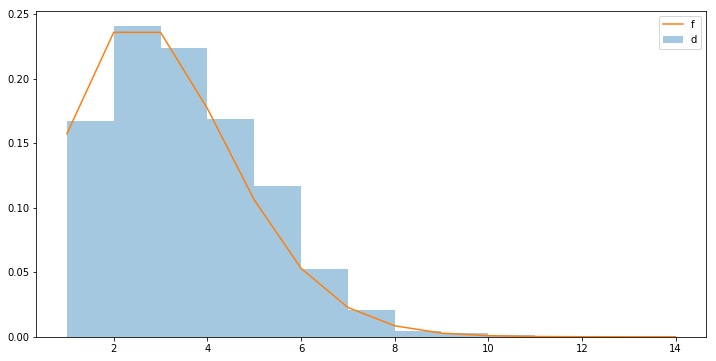

In [10]:
x = sample_truncated_poisson()
plt.figure(figsize=(12,6))
sn.distplot(x, kde=False, norm_hist=True, bins=range(1,15), label = 'd')
sn.lineplot(range(1,15), list(map(truncated_poisson,range(1,15))), label='f')

In [11]:
media = np.mean(x)
var = np.var(x)
print('Estimación de la media:    {}, \nEstimación de la varianza: {}\n'.format(str(media),str(var)))

media_real = 3 / (1 - exp(-3))
var_real = (12/(1 - exp(-3)) - 9 / ((1 - exp(-3))**2))
print('Media real:                {}, \nVarianza real:             {}'.format(str(media_real),str(var_real)))

Estimación de la media:    3.124375124975005, 
Estimación de la varianza: 2.6775922160099075

Media real:                3.157187089473768, 
Varianza real:             2.660918039955231


---
---
---